## ECOMMERCE Customers Segmentation using PCA and K-MEANS

In [1]:
# Importing necessary libraries
import numpy as np
import pandas as pd
pd.set_option('display.max_columns', 150)

# Garbage collection and OS modules
import gc
import os

# Matplotlib and Seaborn for plotting
import matplotlib
matplotlib.rcParams['figure.dpi'] = 120 # Setting resolution
matplotlib.rcParams['figure.figsize'] = (8,6) # Setting figure size

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('darkgrid')
color_palette = sns.color_palette()

# Importing KMeans and silhouette_score from sklearn
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

# Importing PCA (Principal Component Analysis) from sklearn.decomposition
from sklearn.decomposition import PCA


## Data

In [4]:
aisles_data = pd.read_csv('./../data/aisles.csv')
departments_data = pd.read_csv('./../data/departments.csv')
orders_data = pd.read_csv('./../data/orders.csv')
order_products_prior_data = pd.read_csv('./../data/order_products__prior.csv')
order_products_train_data = pd.read_csv('./../data/order_products__train.csv')
products_data = pd.read_csv('./../data/products.csv')


In [5]:
# Inspect the first few rows of each dataframe
print(order_products_prior_data.head())
print(order_products_train_data.head())
print(orders_data.head())
print(products_data.head())
print(aisles_data.head())
print(departments_data.head())

   order_id  product_id  add_to_cart_order  reordered
0         2       33120                  1          1
1         2       28985                  2          1
2         2        9327                  3          0
3         2       45918                  4          1
4         2       30035                  5          0
   order_id  product_id  add_to_cart_order  reordered
0         1       49302                  1          1
1         1       11109                  2          1
2         1       10246                  3          0
3         1       49683                  4          0
4         1       43633                  5          1
   order_id  user_id eval_set  order_number  order_dow  order_hour_of_day  \
0   2539329        1    prior             1          2                  8   
1   2398795        1    prior             2          3                  7   
2    473747        1    prior             3          3                 12   
3   2254736        1    prior             4 

In [6]:
# Check for missing values
print(order_products_train_data.isnull().sum())
print(orders_data.isnull().sum())
print(order_products_prior_data.isnull().sum())
print(products_data.isnull().sum())
print(aisles_data.isnull().sum())
print(departments_data.isnull().sum())

order_id             0
product_id           0
add_to_cart_order    0
reordered            0
dtype: int64
order_id                       0
user_id                        0
eval_set                       0
order_number                   0
order_dow                      0
order_hour_of_day              0
days_since_prior_order    206209
dtype: int64
order_id             0
product_id           0
add_to_cart_order    0
reordered            0
dtype: int64
product_id       0
product_name     0
aisle_id         0
department_id    0
dtype: int64
aisle_id    0
aisle       0
dtype: int64
department_id    0
department       0
dtype: int64


In [7]:
# Fill or drop missing values
orders_data['days_since_prior_order'].fillna(0)

0           0.0
1          15.0
2          21.0
3          29.0
4          28.0
           ... 
3421078    29.0
3421079    30.0
3421080    18.0
3421081     7.0
3421082    30.0
Name: days_since_prior_order, Length: 3421083, dtype: float64

In [8]:
merged_order_products = order_products_prior_data.merge(products_data, on='product_id', how='left')
merged_order_products = merged_order_products.merge(aisles_data, on='aisle_id', how='left')
merged_order_products = merged_order_products.merge(departments_data, on='department_id', how='left')
merged_order_products = merged_order_products.merge(orders_data, on='order_id', how='left')
merged_order_products.shape


(32434489, 15)

In [9]:
merged_order_products.head()

,order_id,product_id,add_to_cart_order,reordered,product_name,aisle_id,department_id,aisle,department,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order
0,2,33120,1,1,Organic Egg Whites,86,16,eggs,dairy eggs,202279,prior,3,5,9,8.0
1,2,28985,2,1,Michigan Organic Kale,83,4,fresh vegetables,produce,202279,prior,3,5,9,8.0
2,2,9327,3,0,Garlic Powder,104,13,spices seasonings,pantry,202279,prior,3,5,9,8.0
3,2,45918,4,1,Coconut Butter,19,13,oils vinegars,pantry,202279,prior,3,5,9,8.0
4,2,30035,5,0,Natural Sweetener,17,13,baking ingredients,pantry,202279,prior,3,5,9,8.0


In [10]:
merged_order_products.user_id.nunique()

206209

## Segmentation

Since there are a lot of different products in our dataset, we'll simplify things by grouping them into categories called "aisles." But even with aisles, we still have too many features to work with. So, we'll use something called Principal Component Analysis (PCA) to help us find new ways of looking at our data that make it easier to group similar items together.

In [11]:
cross_dataframe = pd.crosstab(merged_order_products.user_id, merged_order_products.aisle)
cross_dataframe.head()

aisle,air fresheners candles,asian foods,baby accessories,baby bath body care,baby food formula,bakery desserts,baking ingredients,baking supplies decor,beauty,beers coolers,body lotions soap,bread,breakfast bakery,breakfast bars pastries,bulk dried fruits vegetables,bulk grains rice dried goods,buns rolls,butter,candy chocolate,canned fruit applesauce,canned jarred vegetables,canned meals beans,canned meat seafood,cat food care,cereal,chips pretzels,cleaning products,cocoa drink mixes,coffee,cold flu allergy,condiments,cookies cakes,crackers,cream,deodorants,diapers wipes,digestion,dish detergents,dog food care,doughs gelatins bake mixes,dry pasta,eggs,energy granola bars,energy sports drinks,eye ear care,facial care,feminine care,first aid,food storage,fresh dips tapenades,fresh fruits,fresh herbs,fresh pasta,fresh vegetables,frozen appetizers sides,frozen breads doughs,frozen breakfast,frozen dessert,frozen juice,frozen meals,frozen meat seafood,frozen pizza,frozen produce,frozen vegan vegetarian,fruit vegetable snacks,grains rice dried goods,granola,hair care,honeys syrups nectars,hot cereal pancake mixes,hot dogs bacon sausage,ice cream ice,ice cream toppings,indian foods,instant foods,juice nectars,kitchen supplies,kosher foods,latino foods,laundry,lunch meat,marinades meat preparation,meat counter,milk,mint gum,missing,more household,muscles joints pain relief,nuts seeds dried fruit,oils vinegars,oral hygiene,other,other creams cheeses,packaged cheese,packaged meat,packaged poultry,packaged produce,packaged seafood,packaged vegetables fruits,paper goods,pasta sauce,pickled goods olives,plates bowls cups flatware,popcorn jerky,poultry counter,prepared meals,prepared soups salads,preserved dips spreads,protein meal replacements,red wines,refrigerated,refrigerated pudding desserts,salad dressing toppings,seafood counter,shave needs,skin care,soap,soft drinks,soup broth bouillon,soy lactosefree,specialty cheeses,specialty wines champagnes,spices seasonings,spirits,spreads,tea,tofu meat alternatives,tortillas flat bread,trail mix snack mix,trash bags liners,vitamins supplements,water seltzer sparkling water,white wines,yogurt
user_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,3,0,0,0,0,0,0,0,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,5,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,9,0,0,0,0,8,0,0,0,0,0,2,0,0,0,12,0,0,0,0,0,0,0,0,0,0,0,0,0,13,0,2,0,0,0,0,1,0,0,0,0,0,0,0,0,1
2,0,3,0,0,0,0,2,0,0,0,0,1,1,2,0,0,0,0,0,0,0,0,1,0,0,12,0,0,0,0,5,0,11,0,0,0,0,0,0,0,0,0,6,0,0,0,0,0,0,9,33,0,0,0,0,1,0,0,0,12,0,0,0,4,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,10,0,0,0,0,0,0,0,3,0,1,0,0,5,0,1,0,0,3,0,0,1,0,10,0,0,1,0,0,0,5,0,0,0,0,0,0,0,0,1,0,0,0,0,3,1,1,0,0,0,0,2,0,42
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,6,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,19,0,0,5,0,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,4,0,0,4,0,0,0,0,0,0,0,0,0,0,0,0,0,3,0,0,0,1,5,0,0,0,0,14,1,0,0,0,0,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,15,0,0,0,0,4,1,0,0,0,0,0,2,0,0
4,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,2,2,0,0,0,0,0,0,0,0,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,1,0,0,0,0,0,0,1,1,0,0,1,0,0,0,0,0,1,0,0,0,1,0,0
5,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,4,1,1,6,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,2,0,0,0,0,0,0,0,0,1,0,0,3,0,0,0,0,0,1,0,0,0,1,0,0,0,0,8,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,3


In [12]:
cross_dataframe.tail()

aisle,air fresheners candles,asian foods,baby accessories,baby bath body care,baby food formula,bakery desserts,baking ingredients,baking supplies decor,beauty,beers coolers,body lotions soap,bread,breakfast bakery,breakfast bars pastries,bulk dried fruits vegetables,bulk grains rice dried goods,buns rolls,butter,candy chocolate,canned fruit applesauce,canned jarred vegetables,canned meals beans,canned meat seafood,cat food care,cereal,chips pretzels,cleaning products,cocoa drink mixes,coffee,cold flu allergy,condiments,cookies cakes,crackers,cream,deodorants,diapers wipes,digestion,dish detergents,dog food care,doughs gelatins bake mixes,dry pasta,eggs,energy granola bars,energy sports drinks,eye ear care,facial care,feminine care,first aid,food storage,fresh dips tapenades,fresh fruits,fresh herbs,fresh pasta,fresh vegetables,frozen appetizers sides,frozen breads doughs,frozen breakfast,frozen dessert,frozen juice,frozen meals,frozen meat seafood,frozen pizza,frozen produce,frozen vegan vegetarian,fruit vegetable snacks,grains rice dried goods,granola,hair care,honeys syrups nectars,hot cereal pancake mixes,hot dogs bacon sausage,ice cream ice,ice cream toppings,indian foods,instant foods,juice nectars,kitchen supplies,kosher foods,latino foods,laundry,lunch meat,marinades meat preparation,meat counter,milk,mint gum,missing,more household,muscles joints pain relief,nuts seeds dried fruit,oils vinegars,oral hygiene,other,other creams cheeses,packaged cheese,packaged meat,packaged poultry,packaged produce,packaged seafood,packaged vegetables fruits,paper goods,pasta sauce,pickled goods olives,plates bowls cups flatware,popcorn jerky,poultry counter,prepared meals,prepared soups salads,preserved dips spreads,protein meal replacements,red wines,refrigerated,refrigerated pudding desserts,salad dressing toppings,seafood counter,shave needs,skin care,soap,soft drinks,soup broth bouillon,soy lactosefree,specialty cheeses,specialty wines champagnes,spices seasonings,spirits,spreads,tea,tofu meat alternatives,tortillas flat bread,trail mix snack mix,trash bags liners,vitamins supplements,water seltzer sparkling water,white wines,yogurt
user_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
206205,0,0,1,0,0,0,0,0,0,0,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,3,0,0,2,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,2,0,0,3,0,1,0,0,0,0,0,0,0,3,0,0,2,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,5
206206,0,4,0,0,0,0,4,1,0,0,0,1,1,0,0,0,0,1,5,0,2,0,0,0,1,11,0,0,0,0,2,0,1,16,0,0,0,2,0,0,0,13,7,0,0,0,0,2,0,0,7,7,0,14,3,0,6,0,0,4,0,5,3,0,0,0,0,0,0,0,2,55,0,0,1,5,0,0,0,1,5,0,0,0,0,0,0,0,18,0,0,1,2,3,0,0,0,0,6,3,0,0,5,0,0,0,0,1,0,0,19,0,2,0,0,0,8,8,7,1,3,0,3,0,1,0,0,0,0,1,0,1,0,0
206207,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,5,4,0,0,1,8,0,0,0,0,5,0,5,0,0,0,0,0,0,2,1,4,6,0,0,0,0,0,0,2,17,0,0,18,0,0,1,0,0,0,2,1,9,7,1,1,0,0,0,3,3,1,0,0,0,2,0,0,1,0,6,0,1,18,0,0,0,0,2,1,0,0,1,14,2,0,0,0,15,0,6,0,0,0,0,0,0,0,0,0,3,0,0,0,0,0,0,0,2,0,0,0,4,0,3,4,0,2,1,0,0,11,0,15
206208,0,3,0,0,3,0,4,0,0,0,0,55,0,0,0,0,0,22,2,0,3,6,0,0,13,12,0,0,7,0,6,0,2,16,0,0,0,4,0,5,2,23,35,1,0,0,0,0,0,1,55,23,1,45,0,1,3,0,0,2,0,2,16,0,8,1,2,0,2,2,11,2,0,0,11,2,0,0,0,0,27,2,0,28,0,2,0,0,0,6,0,0,4,11,1,4,3,5,71,0,2,0,2,0,1,0,0,0,0,0,10,0,1,0,0,0,5,0,2,24,0,0,7,0,5,0,0,7,0,0,0,0,0,33
206209,0,1,0,0,0,0,0,0,0,0,0,8,1,0,0,0,0,1,0,0,5,2,0,0,6,1,1,0,0,0,0,1,4,0,0,0,0,2,0,0,1,2,3,0,0,0,0,0,1,4,13,0,0,1,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,3,0,0,0,0,0,0,0,0,0,8,2,0,0,6,0,0,0,0,2,2,0,0,2,5,0,1,0,0,5,1,2,1,0,0,1,0,0,4,0,0,0,0,0,0,0,0,0,10,0,9,0,0,1,0,0,0,0,0,0,1,0,0,0,3


<!-- Normalising each row -->

In [13]:
dataframe = cross_dataframe.div(cross_dataframe.sum(axis=1), axis=0)
dataframe.head()

aisle,air fresheners candles,asian foods,baby accessories,baby bath body care,baby food formula,bakery desserts,baking ingredients,baking supplies decor,beauty,beers coolers,body lotions soap,bread,breakfast bakery,breakfast bars pastries,bulk dried fruits vegetables,bulk grains rice dried goods,buns rolls,butter,candy chocolate,canned fruit applesauce,canned jarred vegetables,canned meals beans,canned meat seafood,cat food care,cereal,chips pretzels,cleaning products,cocoa drink mixes,coffee,cold flu allergy,condiments,cookies cakes,crackers,cream,deodorants,diapers wipes,digestion,dish detergents,dog food care,doughs gelatins bake mixes,dry pasta,eggs,energy granola bars,energy sports drinks,eye ear care,facial care,feminine care,first aid,food storage,fresh dips tapenades,fresh fruits,fresh herbs,fresh pasta,fresh vegetables,frozen appetizers sides,frozen breads doughs,frozen breakfast,frozen dessert,frozen juice,frozen meals,frozen meat seafood,frozen pizza,frozen produce,frozen vegan vegetarian,fruit vegetable snacks,grains rice dried goods,granola,hair care,honeys syrups nectars,hot cereal pancake mixes,hot dogs bacon sausage,ice cream ice,ice cream toppings,indian foods,instant foods,juice nectars,kitchen supplies,kosher foods,latino foods,laundry,lunch meat,marinades meat preparation,meat counter,milk,mint gum,missing,more household,muscles joints pain relief,nuts seeds dried fruit,oils vinegars,oral hygiene,other,other creams cheeses,packaged cheese,packaged meat,packaged poultry,packaged produce,packaged seafood,packaged vegetables fruits,paper goods,pasta sauce,pickled goods olives,plates bowls cups flatware,popcorn jerky,poultry counter,prepared meals,prepared soups salads,preserved dips spreads,protein meal replacements,red wines,refrigerated,refrigerated pudding desserts,salad dressing toppings,seafood counter,shave needs,skin care,soap,soft drinks,soup broth bouillon,soy lactosefree,specialty cheeses,specialty wines champagnes,spices seasonings,spirits,spreads,tea,tofu meat alternatives,tortillas flat bread,trail mix snack mix,trash bags liners,vitamins supplements,water seltzer sparkling water,white wines,yogurt
user_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.016949,0.0,0.000000,0.0,0.000000,0.0,0.050847,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.033898,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.084746,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.152542,0.000000,0.000000,0.0,0.000000,0.135593,0.0,0.000000,0.0,0.0,0.000000,0.033898,0.0,0.000000,0.000000,0.203390,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.220339,0.000000,0.033898,0.0,0.000000,0.0,0.0,0.016949,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.016949
2,0.0,0.015385,0.0,0.0,0.0,0.0,0.010256,0.0,0.0,0.0,0.0,0.005128,0.005128,0.010256,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.005128,0.0,0.000000,0.061538,0.0,0.0,0.0,0.0,0.025641,0.0,0.056410,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.030769,0.0,0.0,0.0,0.0,0.0,0.0,0.046154,0.169231,0.000000,0.000000,0.000000,0.0,0.005128,0.000000,0.0,0.0,0.061538,0.0,0.0,0.0,0.020513,0.0,0.0,0.005128,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000,0.005128,0.0,0.0,0.0,0.0,0.051282,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.015385,0.000000,0.005128,0.0,0.000000,0.025641,0.0,0.005128,0.0,0.0,0.015385,0.000000,0.0,0.005128,0.000000,0.051282,0.0,0.000000,0.005128,0.0,0.0,0.000000,0.025641,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.005128,0.0,0.000000,0.0,0.0,0.015385,0.005128,0.005128,0.000000,0.0,0.0,0.0,0.010256,0.0,0.215385
3,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.

In [14]:
dataframe.shape

(206209, 134)

### PCA and K-Means Clustering

We're going to simplify our data by reducing it to just 10 dimensions using something called Principal Component Analysis (PCA). This is because K-Means Clustering, which we'll use to group similar data points together, doesn't work very well with high-dimensional data. PCA will help us keep the most important information while making it easier for K-Means to do its job effectively. So, instead of dealing with all the features in our dataset, we'll condense it down to just 10 key dimensions.

In [15]:
pca = PCA(n_components=10)
dataframe_pca = pca.fit_transform(dataframe)
dataframe_pca = pd.DataFrame(dataframe_pca)
dataframe_pca.head()

,0,1,2,3,4,5,6,7,8,9
0,-0.113443,0.039084,-0.042863,0.018865,-0.088342,-0.104550,-0.116446,0.083701,-0.062444,-0.026163
1,-0.036988,0.108884,-0.066405,-0.123271,0.098848,-0.033960,-0.054753,-0.053355,-0.020512,-0.007888
2,0.064282,0.103962,0.000710,-0.012221,-0.046983,0.112235,-0.029846,0.007861,0.011990,0.002254
3,-0.093210,0.054093,0.001867,-0.003974,-0.071356,-0.019274,-0.025122,-0.038222,0.006316,-0.000306
4,0.094629,-0.037051,-0.024952,-0.021575,0.055369,0.107644,-0.008027,0.103917,0.051768,-0.026070


In [16]:
Sum_of_squared_distances = []
K = range(1,10)
for k in K:
    km = KMeans(n_clusters=k)
    km = km.fit(dataframe_pca)
    Sum_of_squared_distances.append(km.inertia_)

/Users/aadityakasbekar/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/Users/aadityakasbekar/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/Users/aadityakasbekar/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/Users/aadityakasbekar/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warni

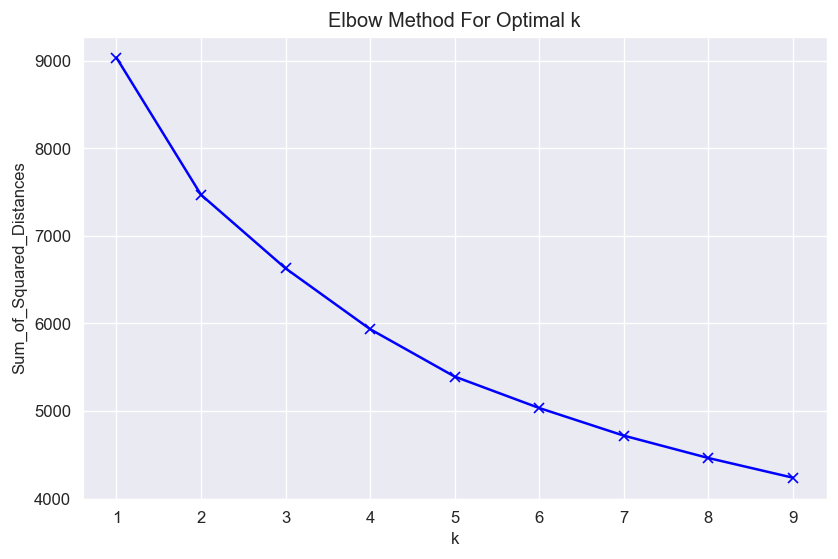

In [17]:
plt.subplots(figsize = (8, 5))
plt.plot(K, Sum_of_squared_distances, 'bx-')
plt.xlabel('k')
plt.ylabel('Sum_of_Squared_Distances')
plt.title('Elbow Method For Optimal k')
plt.show()

<!-- From above graph we can choose optimal K as 5 -->

In [18]:
clusterer_set = KMeans(n_clusters=5,random_state=42).fit(dataframe_pca)
centers = clusterer_set.cluster_centers_
c_preds = clusterer_set.predict(dataframe_pca)
print(centers)

/Users/aadityakasbekar/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


[[-7.42123323e-02 -1.08558851e-02 -2.70141025e-02 -6.84955704e-03
  -6.85765051e-03  1.46416832e-03  5.28491472e-04 -2.55815154e-03
  -3.15408168e-04 -4.23037687e-04]
 [ 1.05854888e-01 -7.35721631e-02  1.73826114e-02  3.80552428e-03
   1.75319506e-03 -4.57610362e-03 -9.42964034e-04  1.25067728e-03
  -1.52081526e-04  7.96218999e-04]
 [-1.98228851e-01  1.61718104e-02  3.17259657e-01 -3.14141545e-02
   1.87505347e-02  6.39443266e-04  4.09151390e-03  1.08544884e-02
   1.14056142e-03 -3.86263244e-03]
 [-5.83284304e-03  1.31222866e-01  4.88656529e-03  2.30139871e-01
   1.10090554e-01 -2.30252253e-02  1.01146524e-04 -6.50132386e-03
   7.85304714e-03  3.06402401e-03]
 [ 6.67078377e-02  1.04216308e-01 -1.40353961e-03 -3.09122053e-02
  -1.02703735e-02  7.48086158e-03 -5.91512745e-04  4.56104171e-03
  -7.51154085e-04 -1.50936729e-04]]


<!-- Visualizing clustering using the first two principal components. -->

In [19]:
temp_dataframe = dataframe_pca.iloc[:, 0:2]
temp_dataframe.columns = ["pc1", "pc2"]
temp_dataframe['cluster'] = c_preds
temp_dataframe.head()

/var/folders/lz/06glpb2526qgqhtf0pvflrz80000gn/T/ipykernel_74727/1560355777.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp_dataframe['cluster'] = c_preds


,pc1,pc2,cluster
0,-0.113443,0.039084,0
1,-0.036988,0.108884,4
2,0.064282,0.103962,4
3,-0.093210,0.054093,0
4,0.094629,-0.037051,1


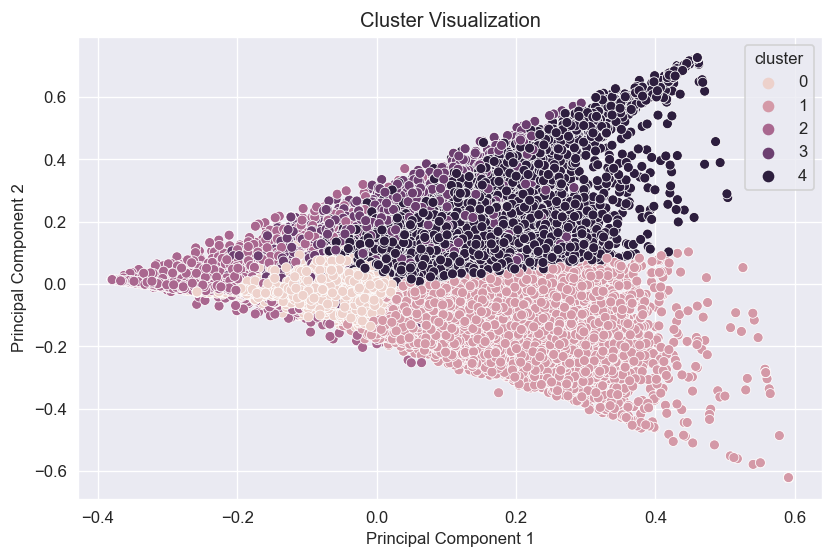

In [20]:
fig, ax = plt.subplots(figsize = (8, 5))
ax = sns.scatterplot(data = temp_dataframe, x = "pc1", y = "pc2", hue = "cluster")
ax.set_xlabel("Principal Component 1")
ax.set_ylabel("Principal Component 2")
ax.set_title("Cluster Visualization")
plt.show();

<!-- Top products within each cluster.  -->




In [21]:
cross_dataframe['cluster'] = c_preds

cluster1 = cross_dataframe[cross_dataframe.cluster == 0]
cluster2 = cross_dataframe[cross_dataframe.cluster == 1]
cluster3 = cross_dataframe[cross_dataframe.cluster == 2]
cluster4 = cross_dataframe[cross_dataframe.cluster == 3]
cluster5 = cross_dataframe[cross_dataframe.cluster == 4]

In [22]:
cluster1.shape

(98785, 135)

In [23]:
cluster1.drop('cluster',axis=1).mean().sort_values(ascending=False)[0:10]

aisle
fresh fruits                     9.692787
fresh vegetables                 7.548606
yogurt                           7.181677
packaged vegetables fruits       5.967951
packaged cheese                  4.919138
chips pretzels                   4.477026
milk                             4.239814
water seltzer sparkling water    4.088222
refrigerated                     3.252660
ice cream ice                    3.097039
dtype: float64

In [24]:
cluster2.shape

(55512, 135)

In [25]:
cluster2.drop('cluster',axis=1).mean().sort_values(ascending=False)[0:10]

aisle
fresh vegetables                 37.074849
fresh fruits                     21.682987
packaged vegetables fruits       11.993425
yogurt                            6.129648
packaged cheese                   5.002306
fresh herbs                       4.155984
milk                              3.987138
soy lactosefree                   3.700335
frozen produce                    3.296440
water seltzer sparkling water     3.075569
dtype: float64

In [26]:
cluster3.shape

(5413, 135)

In [27]:
cluster3.drop('cluster',axis=1).mean().sort_values(ascending=False)[0:10]

aisle
water seltzer sparkling water    20.953815
fresh fruits                      3.337151
soft drinks                       2.801219
yogurt                            2.255311
energy granola bars               1.557362
chips pretzels                    1.346943
tea                               1.327360
milk                              1.327360
packaged vegetables fruits        1.251432
soy lactosefree                   1.082764
dtype: float64

In [28]:
cluster4.shape

(7947, 135)

In [29]:
cluster4.drop('cluster',axis=1).mean().sort_values(ascending=False)[0:10]

aisle
packaged produce                 18.359381
fresh fruits                     10.897697
packaged vegetables fruits        4.232289
fresh vegetables                  3.100038
water seltzer sparkling water     1.715742
milk                              1.616585
packaged cheese                   1.544231
frozen produce                    1.147477
chips pretzels                    1.141185
nuts seeds dried fruit            1.032339
dtype: float64

In [30]:
cluster5.shape

(38552, 135)

In [31]:
cluster5.drop('cluster',axis=1).mean().sort_values(ascending=False)[0:10]

aisle
fresh fruits                     35.701183
fresh vegetables                 15.160433
packaged vegetables fruits       12.180484
yogurt                            9.978159
milk                              5.987212
packaged cheese                   5.167670
soy lactosefree                   3.789168
water seltzer sparkling water     3.628580
bread                             3.220663
chips pretzels                    3.154207
dtype: float64

<!-- Results -->

<!-- 
Customer Segmentation Findings:
- Cluster 1 comprises 8,487 consumers who primarily purchase packaged produce and fresh fruits.
- Cluster 2 consists of 5,582 consumers with a pronounced preference for the water seltzer sparkling water aisle.
- Cluster 3 encompasses 92,944 consumers who order products from a wide range of aisles. However, their average order frequency is relatively low compared to other clusters, suggesting they may be occasional or new Instacart users.
- Cluster 4 includes 47,927 consumers who exhibit a strong preference for fruits, followed by fresh vegetables.
- Cluster 5 involves 51,269 consumers who predominantly order fresh vegetables, followed by fruits. -->

In [32]:
# Customer Segmentation Findings:
# - Cluster 1 comprises 55,860 consumers who predominantly order fresh vegetables, followed by fruits.

# - Cluster 2 includes 5417 consumers with a pronounced preference for the water seltzer sparkling water aisle. 

# - Cluster 3 encompasses 37,816 consumers who exhibit a strong preference for fruits, followed by fresh vegetables.

# - Cluster 4 involves 7949 consumers who primarily purchase packaged produce and fresh fruits.

# - Cluster 5 consists of 99,167 consumers who order products from a wide range of aisles. However, their average 
#   order frequency is relatively low compared to other clusters, suggesting they may be occasional or new Instacart users. 